In [1]:
import json
import os 
import scipy.io
import random
from sklearn.preprocessing import MinMaxScaler # normalize the x,y coordinates
import networkx as nx # for graph
import matplotlib.pyplot as plt
import numpy as np
from generate_graphs import graph_sequence, load_file

Define the nodes for the poses

In [2]:
graph = dict() # initialize graph

points = []
# read the landmarks.m file
with open('landmarks\horse\landmarks.m', 'r') as f:
    for i in f:
        split_result = i.split(' = ')
        if len(split_result) >= 2:
            # print(split_result[1].split(';')[0])
            points.append(split_result[1].split(';')[0].split("'")[1])

# add points to graph
graph['chin'] = ['leftEye', 'rightEye', 'neck']
graph['rightEye'] = ['chin', 'leftEye', 'neck']
graph['leftEye'] = ['chin', 'rightEye', 'neck']
graph['neck'] = ['chin', 'leftEye', 'rightEye', 'leftShoulder', 'rightShoulder']
graph['leftShoulder'] = ['neck', 'frontLeftHip', 'tailStart']
graph['rightShoulder'] = ['neck', 'frontRightHip', 'tailStart']
graph['frontLeftHip'] = ['leftShoulder', 'frontLeftKnee']
graph['frontRightHip'] = ['rightShoulder', 'frontRightKnee']
graph['frontLeftKnee'] = ['frontLeftHip', 'frontLeftHoof']
graph['frontRightKnee'] = ['frontRightHip', 'frontRightHoof']
graph['frontLeftHoof'] = ['frontLeftKnee']
graph['frontRightHoof'] = ['frontRightKnee']
graph['tailStart'] = ['leftShoulder', 'rightShoulder', 'backLeftHip', 'backRightHip']
graph['backLeftHip'] = ['tailStart', 'backLeftKnee']
graph['backRightHip'] = ['tailStart', 'backRightKnee']
graph['backLeftKnee'] = ['backLeftHip', 'backLeftHoof']
graph['backRightKnee'] = ['backRightHip', 'backRightHoof']
graph['backLeftHoof'] = ['backLeftKnee']
graph['backRightHoof'] = ['backRightKnee']

len(graph) == len(points) # check that all points are in graph

True

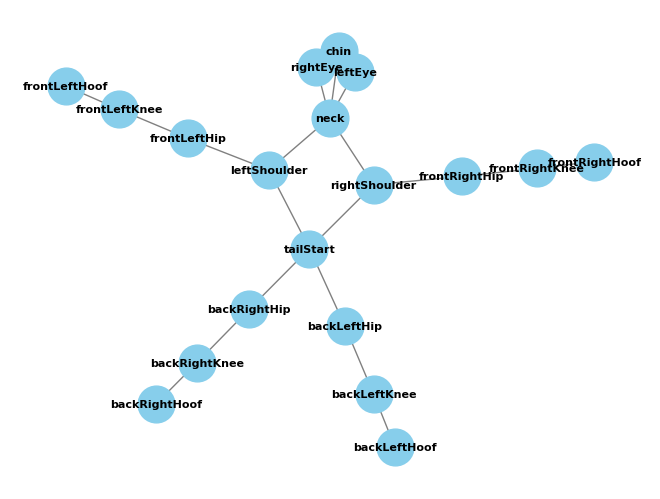

In [3]:
# Create a graph
graph_network = nx.Graph(graph)


# Draw the graph
# pos = nx.spring_layout(graph_network)  # You can choose a different layout algorithm
nx.draw(graph_network, with_labels=True, font_weight='bold', node_size=700, 
        node_color='skyblue', font_color='black', font_size=8, edge_color='gray')

# Display the graph
plt.show()


In [4]:
# save dictionary to JSON file
with open('behavoiur-discovery/graph.json', 'w') as fp:
    json.dump(graph, fp, indent=4)

Define rules to connect the nodes
1. Load the .mat files 
2. Create a graph for each frame and a queue for each file
3. Normalize the x,y coordinates

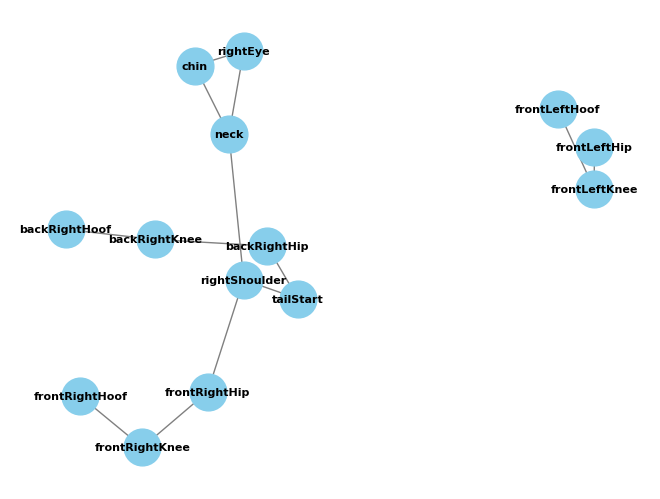

In [20]:

graph_seq = graph_sequence()
first_file_frame = graph_seq['647.mat'][0]
# draw the graph
# pos = nx.spring_layout(first_file_frame)
nx.draw(first_file_frame,  with_labels=True, font_weight='bold', node_size=700, 
        node_color='skyblue', font_color='black', font_size=8, edge_color='gray')

In [17]:
from networkx import NetworkXError
file_647 = graph_seq['647.mat']
# get the adjacency matrix for each frame
# [adjacency_matrix for adjacency_matrix in nx.adjacency_matrix(file_647).todense()]
adj = []
for no, i in enumerate(file_647):
    
    try:
        xc = nx.adjacency_matrix(i).todense()
        adj.append(xc)
    except NetworkXError:
        print(no)
        print('error')
        # continue

33
error
34
error


C:\Users\Austin\AppData\Local\Temp\ipykernel_65608\216763684.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  xc = nx.adjacency_matrix(i).todense()


In [19]:
np.array(adj).shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (33,) + inhomogeneous part.

In [17]:
nx.get_edge_attributes(first_file_frame, 'weight')

{('chin', 'rightEye'): 0.11594149378731733,
 ('chin', 'neck'): 0.1927734989588207,
 ('rightEye', 'neck'): 0.15342313815222755,
 ('neck', 'rightShoulder'): 0.11605311412641597,
 ('rightShoulder', 'frontRightHip'): 0.11255875417085905,
 ('rightShoulder', 'tailStart'): 0.30260955638908393,
 ('frontRightHip', 'frontRightKnee'): 0.1245601996727529,
 ('tailStart', 'backRightHip'): 0.15523511079490943,
 ('frontLeftHip', 'frontLeftKnee'): 0.080491809266813,
 ('frontLeftKnee', 'frontLeftHoof'): 0.10442024232124683,
 ('frontRightKnee', 'frontRightHoof'): 0.10250044793738491,
 ('backRightHip', 'backRightKnee'): 0.10375192918648474,
 ('backRightKnee', 'backRightHoof'): 0.11217126237520313}

In [6]:
nx.to_dict_of_lists(first_file_frame)

{'chin': ['rightEye', 'neck'],
 'rightEye': ['chin', 'neck'],
 'neck': ['chin', 'rightEye', 'rightShoulder'],
 'rightShoulder': ['neck', 'frontRightHip', 'tailStart'],
 'frontRightHip': ['rightShoulder', 'frontRightKnee'],
 'tailStart': ['rightShoulder', 'backRightHip'],
 'frontLeftHip': ['frontLeftKnee'],
 'frontLeftKnee': ['frontLeftHip', 'frontLeftHoof'],
 'frontRightKnee': ['frontRightHip', 'frontRightHoof'],
 'frontLeftHoof': ['frontLeftKnee'],
 'frontRightHoof': ['frontRightKnee'],
 'backRightHip': ['tailStart', 'backRightKnee'],
 'backRightKnee': ['backRightHip', 'backRightHoof'],
 'backRightHoof': ['backRightKnee']}

In [7]:
from node2vec import Node2Vec

# Assuming you have a graph 'G'
node2vec = Node2Vec(first_file_frame, dimensions=64, walk_length=30, num_walks=200, workers=4)


c:\Users\Austin\Desktop\Agent\animal-pose-estimation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 7023.11it/s]


In [8]:
# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)


In [9]:
# Get the embedding for a specific node (e.g., node '0')
model.wv['backRightHoof']


array([ 0.33325917,  0.00305918,  0.35420942,  0.2822716 ,  0.14413178,
        0.11148843,  0.03489264, -0.43204358, -0.46396285, -0.23460376,
        0.27224785, -0.30610737, -0.09946018,  0.0070683 , -0.25086308,
       -0.1417854 , -0.35386586, -0.24183908, -0.10103845,  0.00663463,
        0.16304545,  0.04432049,  0.41139328, -0.05132864, -0.03199434,
        0.29398254, -0.10273346, -0.07847615, -0.6098085 , -0.19501755,
        0.31567046, -0.1822066 , -0.427661  , -0.11750152,  0.157039  ,
        0.07107908, -0.21662726, -0.01639662,  0.03435345,  0.3276718 ,
        0.12707415,  0.05521111, -0.4020276 , -0.2941857 , -0.34959775,
       -0.42693782,  0.01902929, -0.28298616, -0.07230633, -0.05376903,
        0.15689644,  0.24004437,  0.0156197 ,  0.16942976,  0.23776223,
       -0.38671082,  0.1168103 , -0.28820586, -0.13287698,  0.2586206 ,
        0.32404107, -0.49215147,  0.24345814,  0.31283587], dtype=float32)